# Train donkeycar with GPU support in Colab
> Use Colab to train a neural network for a donkey car 

- toc: true
- badges: true
- categories: [donkeycar, Colab]
- image: images/roboCar2020.jpg
- author: Uwe Sterr
- comments: true

# Credit
> Note: This notebook is based on https://colab.research.google.com/github/robocarstore/donkey-car-training-on-google-colab/blob/master/Donkey_Car_Training_using_Google_Colab.ipynb

## Check GPU allocation
If "Found GPU at: / device: GPU: 0" is displayed, the GPU is ready to use.

> Note: Donkeycar at the time of writing in March 2020 uses Tensorflow 1.13, therefore version 1.xx is installed

In [1]:
#collapse-show 
%tensorflow_version 1.13.1
import tensorflow
print(tensorflow.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.13.1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.0


## Git Clone the donkey repository

Get the latest donkeycar from GitHub 
> Note: The default branch is "dev", however, the documentation is for the master branch.

In [2]:
!git clone https://github.com/autorope/donkeycar.git 
%cd /content/donkeycar

!git checkout master

Cloning into 'donkeycar'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 12082 (delta 57), reused 130 (delta 47), pack-reused 11936
Receiving objects: 100% (12082/12082), 65.18 MiB | 29.06 MiB/s, done.
Resolving deltas: 100% (7548/7548), done.
/content/donkeycar
Branch 'master' set up to track remote branch 'master' from 'origin'.
Switched to a new branch 'master'


## Install donkey car
Different to the description at http://docs.donkeycar.com/guide/host_pc/setup_ubuntu/ we create no anaconda environment since the script is supposed to run on Colab which will delete the instance anyway

In [3]:
!pip3 install -e .[pc]

Obtaining file:///content/donkeycar
     |████████████████████████████████| 102kB 8.4MB/s 
  Created wheel for paho-mqtt: filename=paho_mqtt-1.5.0-cp36-none-any.whl size=61416 sha256=47fecced95422f3f8c63e74f832a05698c847da857f7ea0d9edc18cba1d7875f
  Stored in directory: /root/.cache/pip/wheels/02/94/6c/8474137cb7a5a3e001d70a22c8ff919caee69435376bccce79
Successfully built paho-mqtt
  Running setup.py develop for donkeycar


## Create Project
In this step the follwoing actions take place
- create necessary folders (models, data, logs)
- copying necessary files into folders (manage.py, myconfig.py etc.)


In [4]:
!donkey createcar --path /content/mycar

using donkey v3.1.1 ...
Creating car folder: /content/mycar
making dir  /content/mycar
Creating data & model folders.
making dir  /content/mycar/models
making dir  /content/mycar/data
making dir  /content/mycar/logs
Copying car application template: complete
Copying car config defaults. Adjust these before starting your car.
Copying train script. Adjust these before starting your car.
Copying my car config overrides
Donkey setup complete.


## Prepare Data
In order to train the neural network we need to supply trainings data which are recorded on the pi during driving the donkeycar on the track

### Copy the following code and run on pi 
> Note: Copying of the data is much faster if the data is zipped to one file.

```bash
cd ~/mycar/data
tar -czf tub_xx_yyyy_mm_dd.tar.gz tub_xx_yyyy_mm_dd

```

This will create a tub_xx_yyyy_mm_dd.tar.gz file under ~/mycar/data

## Upload Data


### Copy the tub to your local pc

Run this on your local pc if you are using linux/mac
```
sftp pi@raspberry.local
cd ~/mycar/data
get tub_xx_yyyy_mm_dd.tar.gz
```

If you are on a windows, download sftp utility like [filezilla](https://filezilla-project.org/) or [putty](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html)

### Define your tub name here

In [0]:
tub_name="tubVaihingenIIICleaned200126"

### Upload the tub to Google Drive

First upload the tub_x_yyyy_mm_dd.tar.gz to Google Drive. We will then mount Google Drive from colab and copy the data from Drive directly. 
> Note: To copy data from Google Drive to Colab is faster than uplaoding it from local machine.  

When you run the cell below, you will need to click the link and generate an authorization code to for colab to access your drive.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Suppose you upload the tub_xx_yyyy_mm_dd.tar.gz to Google Drive/mycar/tub_xx_yyyy_mm_dd.tar.gz, this is how you copy it from Google Drive to colab

In [7]:
%cd /content/mycar
!rm -rf data
!mkdir data
%cd /content/mycar/data
!cp /content/drive/My\ Drive/myCar/{tub_name}.tar.gz .

/content/mycar
/content/mycar/data


## Upload local files
You can upload files from local machine as well, but probably is slower than above approach downloading files from Google Drive

In [0]:
from google.colab import files
# uploaded = files.upload()

#### Get myconfig.py
> Note: In `myconfig.py` therer are parameters which control the training such as: 
 

```

 line parameter --type to the python manage.py train and drive commands.

 DEFAULT_MODEL_TYPE = 'linear'   (linear|categorical|rnn|imu|behavior|3d|localizer|latent)

 BATCH_SIZE = 128                how many records to use when doing one pass of gradient decent. Use a smaller number if your gpu is running out of memory.

 TRAIN_TEST_SPLIT = 0.8          what percent of records to use for training. the remaining used for validation.

 MAX_EPOCHS = 100                how many times to visit all records of your data

 SHOW_PLOT = True                would you like to see a pop up display of final loss?

 VEBOSE_TRAIN = True             would you like to see a progress bar with text during training?

 USE_EARLY_STOP = True           would you like to stop the training if we see it's not improving fit?

 EARLY_STOP_PATIENCE = 5         how many epochs to wait before no improvement

 MIN_DELTA = .0005               early stop will want this much loss change before calling it improved.

 PRINT_MODEL_SUMMARY = True      print layers and weights to stdout

 OPTIMIZER = None                adam, sgd, rmsprop, etc.. None accepts default

 LEARNING_RATE = 0.001           only used when OPTIMIZER specified

 LEARNING_RATE_DECAY = 0.0       only used when OPTIMIZER specified

 SEND_BEST_MODEL_TO_PI = False   change to true to automatically send best model during training

 CACHE_IMAGES = True             keep images in memory. will speed succesive epochs, but crater if not enough mem.

 

 PRUNE_CNN = False               This will remove weights from your model. The primary goal is to increase performance.

 PRUNE_PERCENT_TARGET = 75        The desired percentage of pruning.

 PRUNE_PERCENT_PER_ITERATION = 20  Percenge of pruning that is perform per iteration.

 PRUNE_VAL_LOSS_DEGRADATION_LIMIT = 0.2  The max amout of validation loss that is permitted during pruning.

 PRUNE_EVAL_PERCENT_OF_DATASET = .05   percent of dataset used to perform evaluation of model.
RNN or 3D  
SEQUENCE_LENGTH = 3             #some models use a number of images over time. This controls how many.  

# # Region of interst cropping
# # only supported in Categorical and Linear models.
ROI_CROP_TOP = 0                    #the number of rows of pixels to ignore on the top of the image  
 ROI_CROP_BOTTOM = 0            #the number of rows of pixels to ignore on the bottom of the image 
```


 



In [8]:
%cd /content/mycar
!cp /content/drive/My\ Drive/myCar/myconfig.py .

/content/mycar


### Upload pre-trained model
Upload model in case you want to use a pre-trained model for transfer learning.
To define which layers shall be trained and which shall be frozen set the parameters in `myconfig.py``

Model transfer options

 When copying weights during a model transfer operation, should we freeze a certain number of layers

 to the incoming weights and not allow them to change during training?

```
FREEZE_LAYERS = False               #default False will allow all layers to be modified by training
NUM_LAST_LAYERS_TO_TRAIN = 7        #when freezing layers, how many layers from the last should be allowed to train?

 ```



In [9]:
%cd /content/mycar/models
!cp /content/drive/My\ Drive/myCar/base_linear.h5 .

/content/mycar/models


And untar it to the right place

In [10]:
%cd /content/mycar/data
!tar -xzf {tub_name}.tar.gz

/content/mycar/data


To check whether data are available lets look at an image

/content/mycar/data/tubVaihingenIIICleaned200126


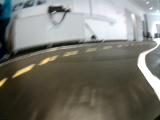

In [13]:
from google.colab import files
from IPython.display import Image
import glob
%cd /content/mycar/data/tubVaihingenIIICleaned200126/
file = glob.glob("*.jpg")
Image(file[100])

## Transfer training of model

Dont forget to set the variables in config.py  


```
FREEZE_LAYERS = True  
`#default False will allow all layers to be modified by training

NUM_LAST_LAYERS_TO_TRAIN = 7  
`#when freezing layers, how many layers from the last should be allowed to train?
```





In [0]:
!python /content/mycar/manage.py train  --type=linear --transfer=/content/mycar/models/base_linear.h5  --model=/content/mycar/models/mypilot.h5


using donkey v3.1.1 ...
loading config file: /content/mycar/config.py
loading personal config over-rides

config loaded
"get_model_by_type" model Type is: linear
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
training with model type <class 'donkeycar.parts.keras.KerasLinear'>
loading weights from model /content/mycar/models/base_linear.h5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
2020-03-01 20:15:10.883730: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-01 20:15:10.947706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had 

## Train your model

In [14]:
!python /content/mycar/manage.py train --type rnn --model /content/mycar/models/mypilot.h5 --aug

using donkey v3.1.1 ...
loading config file: /content/mycar/config.py
loading personal config over-rides

config loaded
sequence of images training
"get_model_by_type" model Type is: rnn
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tub: /content/mycar/data/tubVaihingenIIICleaned200126 has 14234 records
collating records
collating sequences
collated 14169 sequences of length 6
train: 11336, validation: 2833
steps_per_epoch 177
Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-03-02 10:54:21.132316: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-03-02 10:54:21.184607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-03-02 10:54:21.185259: I tensorflow/core/common_runtime/gpu/gp

Check if the model is generated



/content/mycar/models


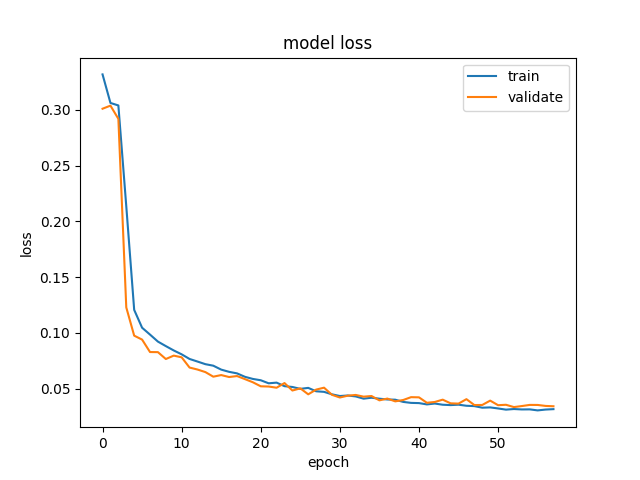

In [15]:
%cd /content/mycar/models
file = glob.glob("*.png")
Image(file[0])

## Copy the trained model back to Donkey Car (Pi)

Once the training is complete on Colab, download


*   mypilot.h5 file from /content/mycar/models/ 
*   myconfig.py file from /content/mycar/





In [21]:
from google.colab import files

files.download('./mypilot.h5')

%cd /content/mycar

files.download('myconfig.py')

/content/mycar


Alternatively, you can copy the model back to Google Drive too

In [0]:
!cp /content/mycar/models/mypilot.h5 /content/drive/My\ Drive/myCar/mypilot.h5

### Copy the file from your PC or Mac to the Raspberry Pi using Filezilla or scp command.

```
sftp pi@raspberry.local
cd mycar/models
put mypilot.h5
```

## Start Autopilot on Pi


```bash
cd ~/mycar
python manage.py drive --model models/mypilot.h5 --js
```


## Bonus - Salient Object Visualization
> Note: It seems like the salient mode doesn't work for RNN networks

In [25]:
# !pip install git+https://github.com/autorope/keras-vis.git
!pip uninstall keras-vis
!pip install git+https://github.com/sctse999/keras-vis
  
  

Uninstalling keras-vis-0.4.1:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/docs/*
    /usr/local/lib/python3.6/dist-packages/keras_vis-0.4.1.dist-info/*
    /usr/local/lib/python3.6/dist-packages/vis/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.6/dist-packages/docs/autogen.py
    /usr/local/lib/python3.6/dist-packages/docs/structure.py
Proceed (y/n)? y
  Successfully uninstalled keras-vis-0.4.1
  Cloning https://github.com/sctse999/keras-vis to /tmp/pip-req-build-fppmjn_o
  Running command git clone -q https://github.com/sctse999/keras-vis /tmp/pip-req-build-fppmjn_o
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=38989 sha256=3425b80d2a4c02e113e49cc0eac6273520739475597a75c838d65a26dba7950b
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ih_t8yg/wheels/29/87/8e/abd2257f08391eabe7552711aecf08cbb50f79877210b21be0
Successfully built keras-vis


In [0]:
%cd /content/mycar
!donkey makemovie --tub data/{tub_name} --model models/mypilot.h5 --type linear --salient

Download the movie to local machine

In [28]:

%cd /content/mycar
!ls -ahl
files.download('tub_movie.mp4')

/content/mycar
total 89M
drwxr-xr-x 6 root root 4.0K Mar  2 11:48 .
drwxr-xr-x 1 root root 4.0K Mar  2 10:52 ..
-rw-r--r-- 1 root root  13K Mar  2 10:51 config.py
drwxr-xr-x 3 root root 4.0K Mar  2 10:52 data
drwxr-xr-x 2 root root 4.0K Mar  2 10:51 logs
-rw-r--r-- 1 root root  23K Mar  2 10:51 manage.py
drwxr-xr-x 2 root root 4.0K Mar  2 11:35 models
-rw-r--r-- 1 root root  14K Mar  2 10:52 myconfig.py
-rw-r--r-- 1 root root 1.8M Mar  2 11:46 mypilot.h5
drwxr-xr-x 2 root root 4.0K Mar  2 10:54 __pycache__
-rw-r--r-- 1 root root  39K Mar  2 10:51 train.py
-rw-r--r-- 1 root root  39M Mar  2 11:50 tub_movie.mp4
-rw------- 1 root root  49M Mar  2 11:46 tubVaihingenIIICleaned200126.tar.gz


Or download the file to Google Drive

In [0]:
!cp /content/mycar/tub_movie.mp4 /content/drive/My\ Drive/myCar/tub_movie.mp4